In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import nltk
from nltk import word_tokenize
import string, re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [4]:
!unzip "/content/drive/MyDrive/SMS-Spam-Detection-main/sms+spam+collection.zip"

Archive:  /content/drive/MyDrive/SMS-Spam-Detection-main/sms+spam+collection.zip
  inflating: SMSSpamCollection       
  inflating: readme                  


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **1. Data Cleaning**

In [5]:
data = pd.read_csv("/content/SMSSpamCollection",  sep = "\t", header = None)
data.rename(columns =  {0:'Category', 1:"Email Text"}, inplace = True)  # rename columns name
data

,Category,Email Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [6]:
data.isnull().sum()

,0
Category,0
Email Text,0


In [7]:
data.duplicated().sum()

403

In [8]:
data = data.drop_duplicates(keep = 'first')

In [9]:
data.duplicated().sum()

0

In [10]:
data = data.reset_index(drop = True)
data

,Category,Email Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5164,spam,This is the 2nd time we have tried 2 contact u...
5165,ham,Will ü b going to esplanade fr home?
5166,ham,"Pity, * was in mood for that. So...any other s..."
5167,ham,The guy did some bitching but I acted like i'd...


In [11]:
data.shape

(5169, 2)

## 2. EDA

In [12]:
print(f"Email Not Spam : {round(data['Category'].value_counts()[0] / len(data) * 100, 2)} %")
print(f"Spam Email : {round(data['Category'].value_counts()[1] / len(data) * 100 , 2)} %")

Email Not Spam : 87.37 %
Spam Email : 12.63 %


<ipython-input-12-fbedb93f055e>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Email Not Spam : {round(data['Category'].value_counts()[0] / len(data) * 100, 2)} %")
<ipython-input-12-fbedb93f055e>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Spam Email : {round(data['Category'].value_counts()[1] / len(data) * 100 , 2)} %")


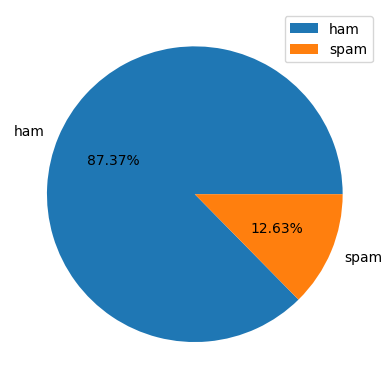

In [13]:
plt.pie(data['Category'].value_counts(),labels = ['ham', 'spam'], autopct = "%.2f%%");
plt.legend();

In [14]:
data['num_characters'] = data['Email Text'].apply(len)
data.head()

,Category,Email Text,num_characters
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [15]:
data['num_words'] = data['Email Text'].apply(lambda x : len(nltk.word_tokenize(x)))
data.head()

,Category,Email Text,num_characters,num_words
0,ham,"Go until jurong point, crazy.. Available only ...",111,24
1,ham,Ok lar... Joking wif u oni...,29,8
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37
3,ham,U dun say so early hor... U c already then say...,49,13
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15


In [16]:
data['num_sent'] = data['Email Text'].apply(lambda x : len(nltk.sent_tokenize(x)))
data.head()

,Category,Email Text,num_characters,num_words,num_sent
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2
1,ham,Ok lar... Joking wif u oni...,29,8,2
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,ham,U dun say so early hor... U c already then say...,49,13,1
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [17]:
data.describe()

,num_characters,num_words,num_sent
count,5169.000000,5169.000000,5169.000000
mean,79.344554,18.593538,1.974076
std,58.437457,13.402779,1.458967
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,61.000000,15.000000,1.000000
75%,119.000000,26.000000,2.000000
max,910.000000,220.000000,38.000000


In [18]:
data[data['Category'] == 'ham'].describe()

,num_characters,num_words,num_sent
count,4516.000000,4516.000000,4516.000000
mean,70.905890,17.267715,1.827724
std,56.715046,13.588065,1.394338
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,53.000000,13.000000,1.000000
75%,91.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [19]:
data[data['Category'] == 'spam'].describe()

,num_characters,num_words,num_sent
count,653.000000,653.000000,653.000000
mean,137.704441,27.762634,2.986217
std,29.821348,6.993008,1.494815
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,148.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,223.000000,46.000000,9.000000


## **3. Data Preprocessing**

* Lower Cases
* Tokenization
* Removing Special Character
* Removing stop Words and punctuation
* Stemming

In [22]:
port_stemmer = PorterStemmer()
lan_stemmer = LancasterStemmer()
lemmatizer = WordNetLemmatizer()

In [23]:
# Create a function to generate cleaned data from raw text
def clean_text(text):
    text = word_tokenize(text) # Create tokens
    text= " ".join(text) # Join tokens
    text = [char for char in text if char not in string.punctuation] # Remove punctuations
    text = ''.join(text) # Join the leters
    text = [char for char in text if char not in re.findall(r"[0-9]", text)] # Remove Numbers
    text = ''.join(text) # Join the leters
    text = [word.lower() for word in text.split() if word.lower() not in set(stopwords.words('english'))] # Remove common english words (I, you, we,...)
    text = ' '.join(text) # Join the leters
    # text = list(map(lambda x: lan_stemmer.stem(x), text.split()))
    text = list(map(lambda x: port_stemmer.stem(x), text.split()))
    # text = list(map(lambda x: lemmatizer.lemmatize(x), text.split()))
    return " ".join(text)   # error word

In [24]:
data['Clean Email'] = data['Email Text'].apply(clean_text)

In [25]:
data.columns

Index(['Category', 'Email Text', 'num_characters', 'num_words', 'num_sent',
       'Clean Email'],
      dtype='object')

In [26]:
data.head(10)

,Category,Email Text,num_characters,num_words,num_sent,Clean Email
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri wkli comp win fa cup final tkt st m...
3,ham,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah nt think goe usf live around though
5,spam,FreeMsg Hey there darling it's been 3 week's n...,147,39,4,freemsg hey darl week word back like fun still...
6,ham,Even my brother is not like to speak with me. ...,77,18,2,even brother like speak treat like aid patent
7,ham,As per your request 'Melle Melle (Oru Minnamin...,160,31,2,per request mell mell oru minnaminungint nurun...
8,spam,WINNER!! As a valued network customer you have...,157,32,5,winner valu network custom select receivea £ p...
9,spam,Had your mobile 11 months or more? U R entitle...,154,31,3,mobil month u r entitl updat latest colour mob...


In [27]:
from wordcloud import WordCloud
wc = WordCloud(width = 2000, height = 1000, min_font_size = 10, background_color = 'Black')

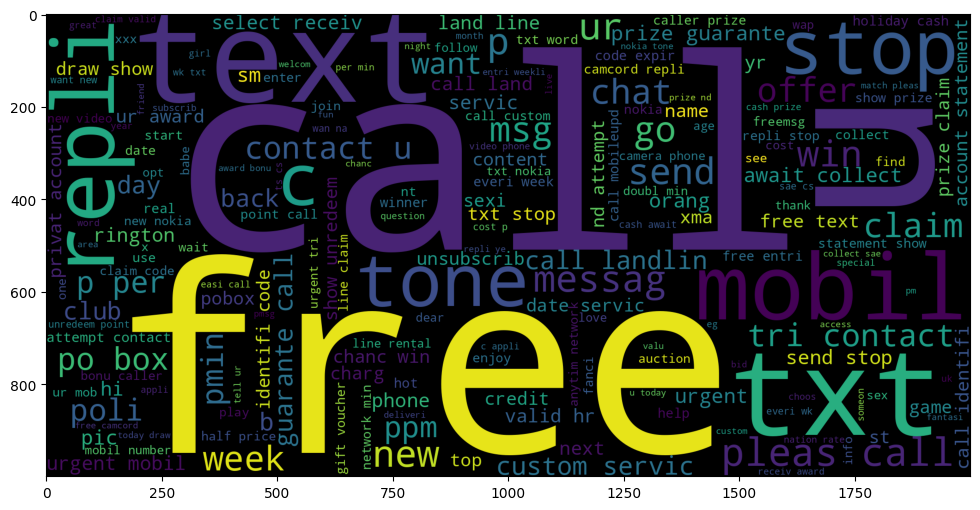

In [28]:
spam_ = wc.generate(data[data['Category']=='spam']['Clean Email'].str.cat(sep = " "));
plt.figure(figsize = (15,6))
plt.imshow(spam_);

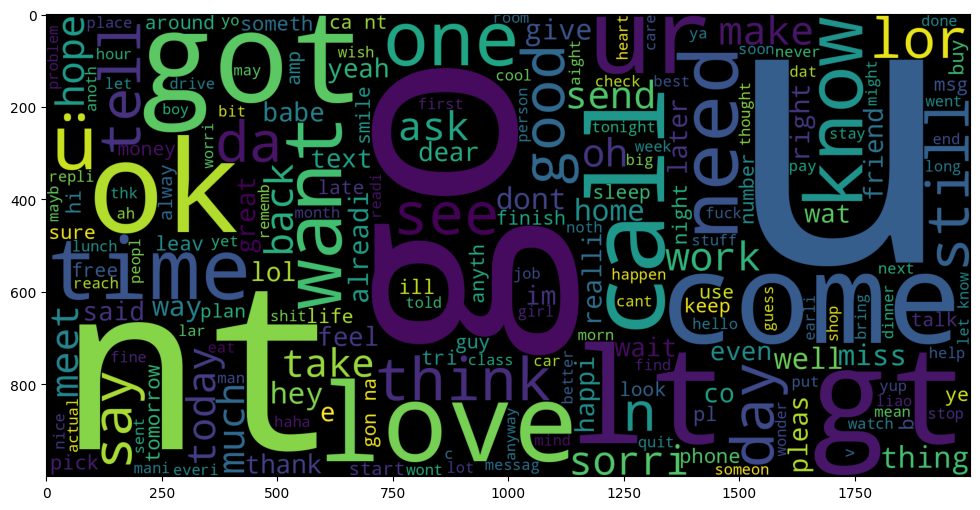

In [29]:
ham_ = wc.generate(data[data['Category']=='ham']['Clean Email'].str.cat(sep = " "));
plt.figure(figsize = (15,6))
plt.imshow(ham_);

In [30]:
spam_word = []
for msg in data[data['Category'] == 'spam']['Clean Email'].tolist():
  for word in msg.split():
    spam_word.append(word)

In [31]:
len(spam_word)

9553

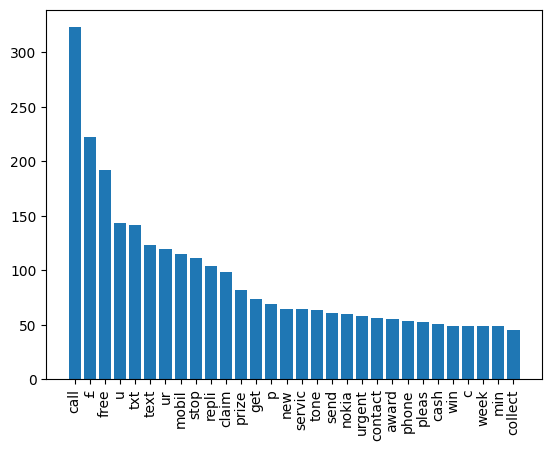

In [32]:
from collections import Counter # Count frequence of word in text
plt.bar(pd.DataFrame(Counter(spam_word).most_common(30))[0], pd.DataFrame(Counter(spam_word).most_common(30))[1])
plt.xticks(rotation = 'vertical');

In [33]:
ham_word = []
for msg in data[data['Category'] == 'ham']['Clean Email'].tolist():
  for word in msg.split():
    ham_word.append(word)

In [34]:
len(ham_word)

36329

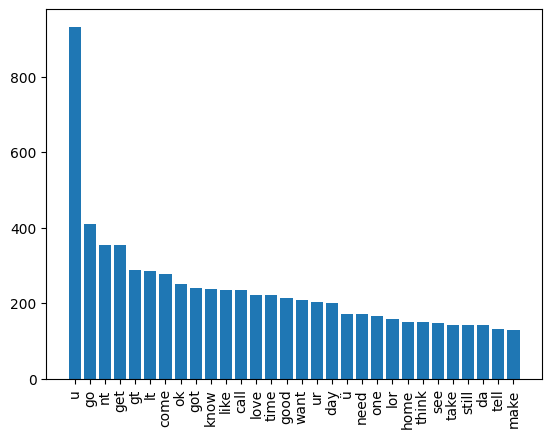

In [35]:
from collections import Counter # Count frequence of word in text
plt.bar(pd.DataFrame(Counter(ham_word).most_common(30))[0], pd.DataFrame(Counter(ham_word).most_common(30))[1])
plt.xticks(rotation = 'vertical');

In [36]:
from sklearn.preprocessing import LabelEncoder


# Initialize the LabelEncoder
encoder = LabelEncoder()

# Fit and transform the labels
data['target'] = encoder.fit_transform(data['Category'])

## 4. Model Building

In [37]:
from sklearn.feature_extraction.text import CountVectorizer ,TfidfVectorizer

cv = CountVectorizer

In [38]:
# Initialize the TF-IDF vectorizer
tf = TfidfVectorizer(max_features = 3000)

# Fit and transform the text column
X = tf.fit_transform(data['Clean Email']).toarray()
X.shape

(5169, 3000)

In [39]:
y = data['target'].values

In [40]:
y

array([0, 0, 1, ..., 0, 0, 0])

In [41]:
from sklearn.model_selection import train_test_split

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2)

In [43]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, recall_score, f1_score, roc_auc_score, mean_squared_error, r2_score, log_loss

In [44]:
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

In [45]:
gnb.fit(X_train, y_train)
y_pred1 = gnb.predict(X_test)
print(f"Accuracy Score: {accuracy_score(y_test, y_pred1)}")
print(confusion_matrix(y_test, y_pred1))
print(f"Precision Score {precision_score(y_test, y_pred1)}")

Accuracy Score: 0.8607350096711799
[[788 120]
 [ 24 102]]
Precision Score 0.4594594594594595


In [46]:
mnb.fit(X_train, y_train)
y_pred2 = mnb.predict(X_test)
print(f"Accuracy Score: {accuracy_score(y_test, y_pred2)}")
print(confusion_matrix(y_test, y_pred2))
print(f"Precision Score {precision_score(y_test, y_pred2)}")

Accuracy Score: 0.9709864603481625
[[908   0]
 [ 30  96]]
Precision Score 1.0


In [ ]:
bnb.fit(X_train, y_train)
y_pred3 = bnb.predict(X_test)
print(f"Accuracy Score: {accuracy_score(y_test, y_pred3)}")
print(confusion_matrix(y_test, y_pred3))
print(f"Precision Score {precision_score(y_test, y_pred3)}")

Accuracy Score: 0.9796905222437138
[[906   2]
 [ 19 107]]
Precision Score 0.981651376146789


In [47]:
import pickle

pickle.dump(tf, open('vectorizer.pkl', 'wb'))
pickle.dump(mnb, open('model.pkl', 'wb'))

# tf , mnb

In [48]:
sms = "“We’re happy to inform you that you’re entitled to a refund for overpayment on your AMEX account. Click on this link [Link] below to claim your refund.”"

In [49]:
tf_idf = pickle.load(open("/content/vectorizer.pkl", 'rb'))
models = pickle.load(open("/content/model.pkl", 'rb'))

In [50]:
# 1. Preprocess
transformed_sms = clean_text(sms)

# 2. Vectorize
vect_input = tf_idf.transform([transformed_sms])

# 3. Predict
result = models.predict(vect_input)[0]

# 4. Display
if result == 1:
  print("Spam")
else:
  print("Not Spam")

Spam


## Multiple Model

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [52]:
models = []
models.append(('Logistic Regression', LogisticRegression()) )
models.append((('Decision Tree Classifier', DecisionTreeClassifier())))
models.append(('Random Forest Classifier', RandomForestClassifier()))
models.append(('Naive bayes', MultinomialNB()))
models.append(('KNeighborsClassifier', KNeighborsClassifier()))
models.append(('Support Vector Machine', SVC()))

In [53]:
models

[('Logistic Regression', LogisticRegression()),
 ('Decision Tree Classifier', DecisionTreeClassifier()),
 ('Random Forest Classifier', RandomForestClassifier()),
 ('Naive bayes', MultinomialNB()),
 ('KNeighborsClassifier', KNeighborsClassifier()),
 ('Support Vector Machine', SVC())]

In [54]:
Model = []
Accuracy = []
Precision = []
Recall = []
F1 = []
for name, model in models:

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    Model.append(name)
    Accuracy.append(round(accuracy_score(y_test, y_pred), 4) * 100)
    Precision.append(round(precision_score(y_test, y_pred), 4) * 100)
    Recall.append(round(recall_score(y_test, y_pred), 4) * 100)
    F1.append(round(f1_score(y_test, y_pred), 4) * 100)

df = pd.DataFrame({'Model': Model, 'Accuracy':Accuracy, 'Precision':Precision, 'Recall':Recall, 'F1 Score':F1})

In [55]:
df = df.sort_values(by = 'Precision', ascending = False).reset_index(drop = True)
df

,Model,Accuracy,Precision,Recall,F1 Score
0,Naive bayes,97.10,100.00,76.19,86.49
1,KNeighborsClassifier,91.88,100.00,33.33,50.00
2,Support Vector Machine,97.29,99.00,78.57,87.61
3,Random Forest Classifier,97.49,98.08,80.95,88.70
4,Logistic Regression,95.16,97.50,61.90,75.73
5,Decision Tree Classifier,95.07,82.61,75.40,78.84


In [56]:
df = df.sort_values(by = 'F1 Score', ascending = False).reset_index(drop = True)
df

,Model,Accuracy,Precision,Recall,F1 Score
0,Random Forest Classifier,97.49,98.08,80.95,88.70
1,Support Vector Machine,97.29,99.00,78.57,87.61
2,Naive bayes,97.10,100.00,76.19,86.49
3,Decision Tree Classifier,95.07,82.61,75.40,78.84
4,Logistic Regression,95.16,97.50,61.90,75.73
5,KNeighborsClassifier,91.88,100.00,33.33,50.00


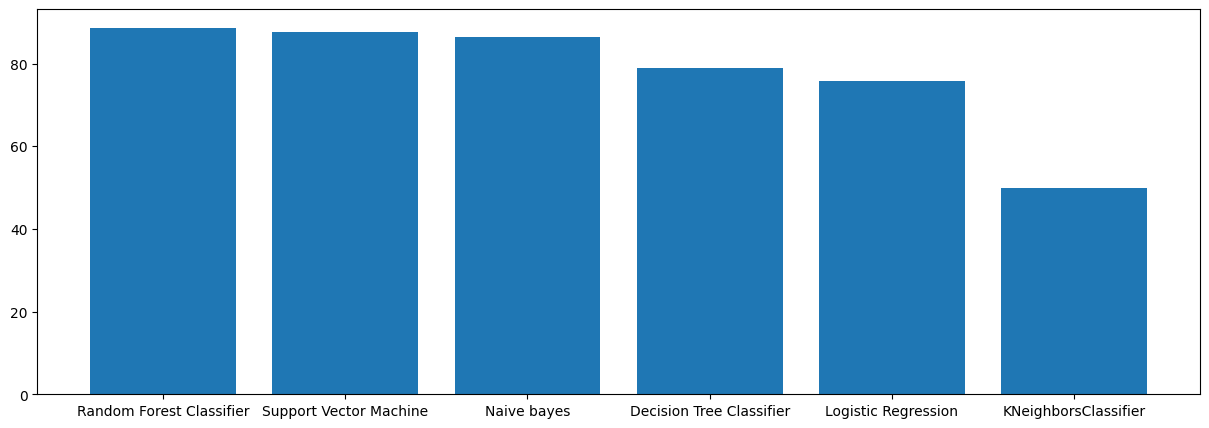

In [57]:
plt.figure(figsize = (15,5))
plt.bar(df['Model'],df['F1 Score']);